In [ ]:
from jetstream_hugo.jet_finding import *
from jetstream_hugo.definitions import *
from jetstream_hugo.plots import *
from jetstream_hugo.clustering import *
from jetstream_hugo.data import *
import colormaps
from matplotlib.ticker import MaxNLocator

%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext line_profiler

/storage/homefs/hb22g102/miniforge3/envs/env11_2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# jet detection demo + comparison with S17

In [1]:
from dynlib.detect import jetaxis
from dynlib import dynfor
dynfor.config.jetint_thres = 1.e-11

In [3]:
from itertools import pairwise


def find_jets_spensberger(ds, no: int = 4000, nf: int = 100):
    ds = coarsen_da(ds, 1.5)
    dx, dy = compute_dx_dy(ds)
    lon_da = ds.lon.assign_coords(lon=("lon", np.arange(len(ds.lon))))
    lat_da = ds.lat.assign_coords(lat=("lat", np.arange(len(ds.lat))))
    u_smo = smooth(ds["u"], smooth_map={"lon+lat": ("fft", 0.2)})
    v_smo = smooth(ds["v"], smooth_map={"lon+lat": ("fft", 0.2)})
    all_points, all_group_ends = jetaxis(no, nf, u_smo.values, v_smo.values, dx, dy)
    jets = []
    for points, group_ends in zip(all_points, all_group_ends):
        end = np.argmax(group_ends[1:] == 0) + 1
        if end == 1:
            continue
        jets.append([])
        x, y, s = points.T
        x = lon_da.interp(lon=x, method="linear").values
        y = lat_da.interp(lat=y, method="linear").values
        group = np.asarray([x, y, s]).T
        for istart, iend in pairwise(group_ends[:end].astype(int)):
            jets[-1].append(pd.DataFrame(group[istart:iend], columns=["lon", "lat", "s"]))
    return all_jets_to_one_df(jets, ds.time.values)

In [4]:
ds = xr.open_dataset(f"/storage/workspaces/giub_meteo_impacts/ci01/ERA5/plev/results/5/ds.nc", chunks="auto").isel(time=slice(1200)).load()

In [5]:
all_jets_spensberger = find_jets_spensberger(ds)

 preparing
all jets to one df


100%|██████████| 1200/1200 [00:02<00:00, 597.56it/s]


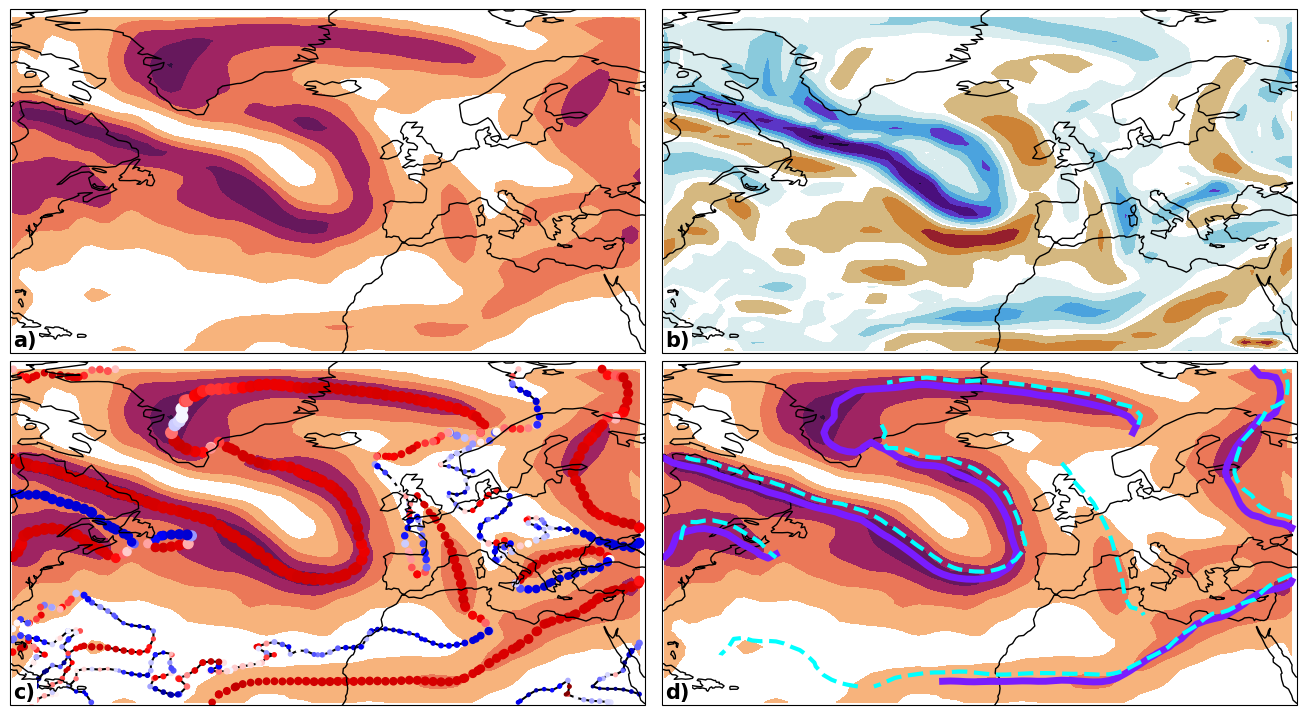

In [13]:
clu = Clusterplot(2, 2, get_region(ds))
# it = np.random.randint(0, ds.time.shape[0])
# ds_ = preprocess(ds.isel(time=it), smooth_s=0.2)
t = np.datetime64('1959-10-09T00:00:00.000000000')
ds_ = preprocess(ds.sel(time=t), smooth_s=0.2)
lon, lat = ds_.lon.values, ds_.lat.values
levels_wind = np.arange(0, 100, 15)
cmap1 = colormaps.matter
cmap1 = make_transparent(cmap1, len(levels_wind), 1, 1, 1)
cmap2 = colormaps.fusion_r
levels_sigma = np.linspace(-0.00013, 0.00013, 13)
cmap2 = make_transparent(cmap2, len(levels_sigma), 1, 1, 0)


ax = clu.axes[0]
ax.contourf(lon, lat, ds_["s"], cmap=cmap1, levels=levels_wind)

ax = clu.axes[1]
ax.contourf(lon, lat, ds_["sigma"], cmap=cmap2, levels=levels_sigma)

ax = clu.axes[2]
dx = (ds_.lon[1] - ds_.lon[0]).item()
contours, types = contour_generator(x=lon, y=lat, z=ds_["sigma"].values, line_type="SeparateCode", quad_as_tri=False).lines(0.)
ax.contourf(lon, lat, ds_["s"], cmap=cmap1, levels=levels_wind)
groups = []
for contour, types_ in zip(contours, types):
    if len(contour) < 15:
        continue
    group = interp_xy_ds(ds_, contour[::-1])
    group = compute_alignment(group)
    x, y, s, alignment = group.to_dataframe()[["lon", "lat", "s", "alignment"]].to_numpy().T
    ax.plot(x, y, lw=1.5, color="black", zorder=-10)
    ax.scatter(x, y, c=alignment, s=s, cmap=colormaps.BlWhRe, vmin=-1.5, vmax=1.5)
    
ax = clu.axes[3]
wind_threshold: float = 23
jet_threshold: float = 1.e8
alignment_threshold: float = 0.4
mean_alignment_threshold: float = 0.7
contours, types = contour_generator(x=lon, y=lat, z=ds_["sigma"].values, line_type="SeparateCode", quad_as_tri=False).lines(0.)
ax.contourf(lon, lat, ds_["s"], cmap=cmap1, levels=levels_wind)
groups = []
levels_lev = MaxNLocator(8).tick_values(ds_.lev.min().item(), 300)
cmap = colormaps.matter_r
norm = BoundaryNorm(levels_lev, cmap.N)
for contour, types_ in zip(contours, types):
    if len(contour) < 15:
        continue
    cyclic: bool = 79 in types_ # code for line closing 
    group = interp_xy_ds(ds_, contour[::-1])
    group = compute_alignment(group)
    mask = (group["alignment"] > alignment_threshold) & (group["s"].values > wind_threshold)
    mask = mask.values
    indicess = get_runs_fill_holes(mask, hole_size=5, cyclic=cyclic)
    for indices in indicess:
        indices = np.unique(indices)
        if len(indices) < 5:
            continue
        group_df = group.to_dataframe().drop(columns="time").iloc[indices] # remove time
        group_ = group_df[["lon", "lat"]].values.astype(np.float32)
        labels = AgglomerativeClustering(n_clusters=None, distance_threshold=dx * 1.9, linkage="single").fit(group_).labels_
        masks = labels_to_mask(labels)
        for mask in masks.T:
            groups.append(group_df.iloc[mask])
jets = []
for group_df in groups:
    bigjump = np.diff(group_df["lon"]) < -3 * dx
    if any(bigjump):
        here = np.where(bigjump)[0][0] + 1
        group_df = group_df.apply(np.roll, args=(-here,), raw=True)
    if "P" in group_df and any(group_df["P"] < 0):
        continue
    group_ = group_df[["lon", "lat", "s"]].values.astype(np.float32)
    jet_int = jet_integral_haversine(group_)
    mean_alignment = np.mean(group_df["alignment"].values)
    if jet_int > jet_threshold and mean_alignment > mean_alignment_threshold:
        jets.append(group_df)
for jet in jets:
    x, y, s, P, alignment = jet[["lon", "lat", "s", "lev", "alignment"]].to_numpy().T
    # im = ax.scatter(x, y, c=P, cmap=cmap, norm=norm)
    ax.plot(x, y, color=COLORS[1], lw=5)
    
jets_spensberger = all_jets_spensberger.loc[t]
for jid, jet in jets_spensberger.groupby(level=0):
    i = int(jid[1:])
    ax.plot(*jet[["lon", "lat"]].to_numpy().T, color="cyan", linestyle="dashed", lw=3)
    
for ax, letter in zip(clu.axes, list("abcd")):
    ax.annotate(f"{letter})", (2.2, 5.1), xycoords='axes points', ha="left", va="baseline", fontweight="demi", fontsize=15, bbox={"boxstyle": "square, pad=0.1", "edgecolor": "none", "facecolor": "white"}, usetex=False)
    
plt.savefig(f"{FIGURES}/jet_detection_demo/full.png")

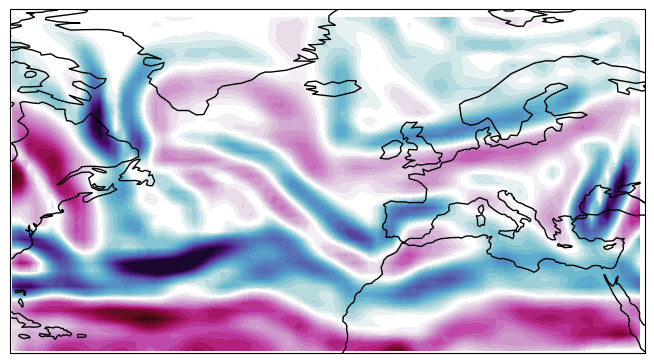

In [ ]:
clu = Clusterplot(1, 1, get_region(ds))
_ = clu.add_contourf([ds_["sigma"]], cmap=colormaps.viola, transparify=0, draw_cbar=False, nlevels=21)
plt.savefig(f"{FIGURES}/jet_detection_demo/sigma.png")

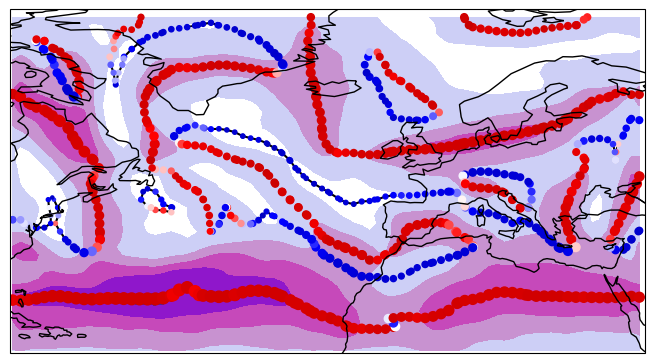

In [18]:
clu = Clusterplot(1, 1, get_region(ds))
lon, lat = ds_.lon.values, ds_.lat.values
ax = clu.axes[0]
dx = (ds_.lon[1] - ds_.lon[0]).item()
ds_ = preprocess(ds.isel(time=it), smooth_s=0.2)
contours, types = contour_generator(x=lon, y=lat, z=ds_["sigma"].values, line_type="SeparateCode", quad_as_tri=False).lines(0.)
_ = clu.add_contourf([ds_["s"]], cmap=colormaps.gothic_r, transparify=1, draw_cbar=False, nlevels=8)
groups = []
for contour, types_ in zip(contours, types):
    if len(contour) < 15:
        continue
    group = interp_xy_ds(ds_, contour[::-1])
    group = compute_alignment(group)
    x, y, s, alignment = group.to_dataframe()[["lon", "lat", "s", "alignment"]].to_numpy().T
    ax.plot(x, y, lw=1.5, color="black", zorder=-10)
    ax.scatter(x, y, c=alignment, s=s, cmap=colormaps.BlWhRe, vmin=-1.5, vmax=1.5)
plt.savefig(f"{FIGURES}/jet_detection_demo/contours.png")

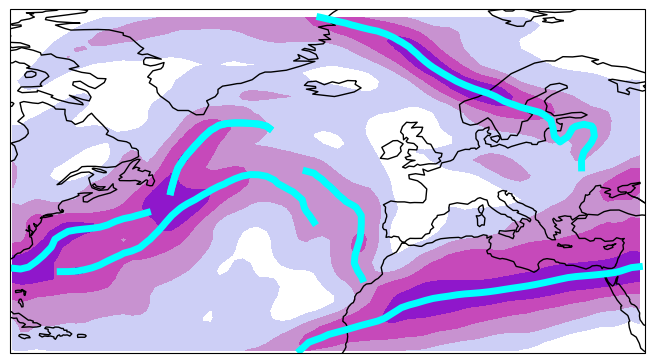

In [37]:
from matplotlib.ticker import MaxNLocator
clu = Clusterplot(1, 1, get_region(ds))
ax = clu.axes[0]
it = np.random.randint(0, ds.time.shape[0])
ds_ = preprocess(ds.isel(time=it), smooth_s=0.2)
lon, lat = ds_.lon.values, ds_.lat.values
dx = (ds_.lon[1] - ds_.lon[0]).item()
wind_threshold: float = 21
jet_threshold: float = 1.e8
alignment_threshold: float = 0.3
mean_alignment_threshold: float = 0.7
contours, types = contour_generator(x=lon, y=lat, z=ds_["sigma"].values, line_type="SeparateCode", quad_as_tri=False).lines(0.)
_ = clu.add_contourf([ds_["s"]], cmap=colormaps.gothic_r, transparify=1, draw_cbar=False, nlevels=8)
groups = []
levels = MaxNLocator(8).tick_values(ds_.lev.min().item(), 300)
cmap = colormaps.matter_r
norm = BoundaryNorm(levels, cmap.N)
for contour, types_ in zip(contours, types):
    if len(contour) < 15:
        continue
    cyclic: bool = 79 in types_ # code for line closing 
    group = interp_xy_ds(ds_, contour[::-1])
    group = compute_alignment(group)
    mask = (group["alignment"] > alignment_threshold) & (group["s"].values > wind_threshold)
    mask = mask.values
    indicess = get_runs_fill_holes(mask, hole_size=5, cyclic=cyclic)
    for indices in indicess:
        indices = np.unique(indices)
        if len(indices) < 5:
            continue
        group_df = group.to_dataframe().drop(columns="time").iloc[indices] # remove time
        group_ = group_df[["lon", "lat"]].values.astype(np.float32)
        labels = AgglomerativeClustering(n_clusters=None, distance_threshold=dx * 1.9, linkage="single").fit(group_).labels_
        masks = labels_to_mask(labels)
        for mask in masks.T:
            groups.append(group_df.iloc[mask])
jets = []
for group_df in groups:
    bigjump = np.diff(group_df["lon"]) < -3 * dx
    if any(bigjump):
        here = np.where(bigjump)[0][0] + 1
        group_df = group_df.apply(np.roll, args=(-here,), raw=True)
    if "P" in group_df and any(group_df["P"] < 0):
        continue
    group_ = group_df[["lon", "lat", "s"]].values.astype(np.float32)
    jet_int = jet_integral_haversine(group_)
    mean_alignment = np.mean(group_df["alignment"].values)
    if jet_int > jet_threshold and mean_alignment > mean_alignment_threshold:
        jets.append(group_df)
for jet in jets:
    x, y, s, P, alignment = jet[["lon", "lat", "s", "lev", "alignment"]].to_numpy().T
    # im = ax.scatter(x, y, c=P, cmap=cmap, norm=norm)
    ax.plot(x, y, color="cyan", lw=5)
# plt.colorbar(im, shrink=0.8)
plt.savefig(f"{FIGURES}/jet_detection_demo/jets.png")

In [ ]:
exp = MultiVarExperiment("ERA5", "plev", ["u", "v", "s"], "6H", [2021], None, -80, 40, 15, 80, [200, 250, 300])
all_jets_one_df, where_are_jets, all_jets_one_array, all_jets_over_time, flags = exp.track_jets(processes=20, chunksize=100)
props_as_ds_uncat = exp.props_as_ds(False, processes=20, chunksize=100)
props_as_ds = exp.props_as_ds(True)
ds = exp.ds
da = exp.ds["s"]

jet_pos_da = jet_position_as_da(da, props_as_ds_uncat, all_jets_one_df, exp.path, processes=20, chunksize=100)
jet_pos_da = coarsen_da(jet_pos_da, 1.5)
props_as_ds["nao"] = get_nao(props_as_ds)
overlap = (jet_pos_da > 0).any("lat").all("jet")
props_as_ds["double_jet_index"] = overlap.sel(lon=slice(-20, None, None)).mean("lon")

[########################################] | 100% Completed | 38.62 s
Finding all jets


100%|██████████| 1460/1460 [00:33<00:00, 43.31it/s]


all jets to one df


100%|██████████| 1460/1460 [00:01<00:00, 956.63it/s] 


Tracking jets


  0%|          | 0/1459 [00:00<?, ?it/s]/storage/homefs/hb22g102/miniforge3/envs/env11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/storage/homefs/hb22g102/miniforge3/envs/env11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 1459/1459 [00:06<00:00, 224.07it/s]


Computing jet properties


100%|██████████| 1036/1036 [00:02<00:00, 358.45it/s]


computing com_speed


100%|██████████| 1036/1036 [00:01<00:00, 547.25it/s]


Jet position as da


100%|██████████| 1460/1460 [00:03<00:00, 479.01it/s]


# Extreme climatology

In [2]:
sparse_exp = MultiVarExperiment("ERA5", "plev", ["u", "v", "s"], "6H", np.arange(1960, 2022, 5).tolist(), None, -80, 40, 15, 80, [175, 200, 225, 250, 300, 350])

In [3]:
ds = sparse_exp.ds.load()
q_clim = compute_clim(ds["s"].quantile(np.arange(0.6, 1, 0.05), ["lon", "lat"]), "dayofyear")
q_clim = smooth(q_clim, {"dayofyear": ("win", 61)}).load()
q_clim.to_netcdf(f"{DATADIR}/ERA5/plev/results/s_q_clim.nc")

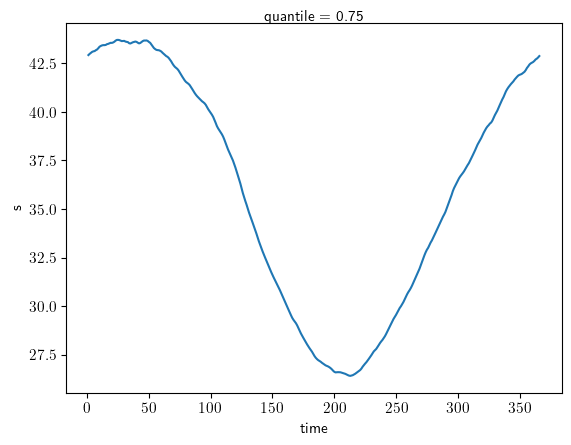

In [9]:
q_clim.isel(quantile=3).plot()

# Anim track demo

In [2]:
exp = MultiVarExperiment("ERA5", "plev", ["u", "v", "s"], "6H", "all", None, -80, 40, 15, 80, [175, 200, 225, 250, 300, 350])
all_jets_one_df, where_are_jets, all_jets_one_array, all_jets_over_time, flags = exp.track_jets(processes=N_WORKERS, chunksize=100)
props_as_ds_uncat = exp.props_as_ds(False, processes=N_WORKERS, chunksize=100)
ds = exp.ds

flags = xr.DataArray(flags, coords={"time": ds.time.values, "jet": np.arange(flags.shape[1])})
slice_ = slice(pd.Timestamp("2020", unit="Y"), pd.Timestamp("2021", unit="Y"))
these_jets = all_jets_one_df.loc[slice_]
flags = flags.loc[slice_]
da = ds["s"].loc[slice_]

MovieWriter ffmpeg unavailable; using Pillow instead.


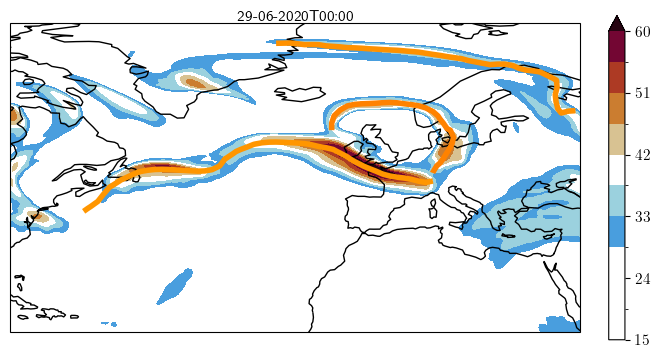

In [3]:
from matplotlib.collections import LineCollection, PathCollection
from matplotlib.animation import FuncAnimation

clu = Clusterplot(1, 1, exp.region)
fig = clu.fig
ax = clu.axes[0]
times = da.time.values
lon, lat = da.lon.values, da.lat.values
kwargs_contourf, _, _, _ = clu.setup_contourf(
    [da.isel(time=0)], transparify=3, q=0.9, nlevels=11,
)
cs = ax.contourf(
    lon, lat, da.isel(time=0).values, **kwargs_contourf
)
minflag = flags.min()
flags_ = flags.copy()
flags_ -= minflag
maxflag = int(np.nanmax(flags_.where(flags_ < flags.max())))
nturns = 30
flag_colors = colormaps.BlAqGrYeOrReVi200(np.linspace(0, nturns, maxflag) % 1)
segments = []
colors = []
for j, (_, jet) in enumerate(these_jets.loc[times[0]].groupby(level=0)):
    segments.append(jet[["lon", "lat"]].to_numpy())
    colors.append(flag_colors[flags_.loc[times[0], j]])
lc = LineCollection(segments, colors=colors, lw=4)
ax.add_collection(lc)
cbar = fig.colorbar(cs)

def animate(i):
    global lc
    global cs
    try:
        these_jets.loc[times[i]]
    except KeyError:
        return lc, cs
    cs.remove()
    segments = []
    colors = []
    for j, (_, jet) in enumerate(these_jets.loc[times[i]].groupby(level=0)):
        segments.append(jet[["lon", "lat"]].to_numpy())
        colors.append(flag_colors[flags_.loc[times[i], j]])
    lc.set_segments(segments)
    lc.set_colors(colors)
    cs = ax.contourf(
        lon, lat, da.isel(time=i).values, **kwargs_contourf
    )
    ax.set_title(da.time[i].dt.strftime("%d-%m-%YT%H:00").item())
    return lc, cs


ani = FuncAnimation(fig, animate, frames=np.arange(6 * 4 * 30, 8 * 4 * 30 + 60, 4))
ani.save(f"{FIGURES}/jet_anim.gif", dpi=200, fps=1)